# 初探Pytorch核心概念

本文主要参考[DEEP LEARNING WITH PYTORCH: A 60 MINUTE BLITZ](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)。完全参照官方文档，并查询资料补充官方文档中不是太好懂的内容，主要涉及一些基本的概念和使用pytorch的方法：

- autograd的基本概念
- torch.nn使用介绍
- 训练分类器实例

最后一部分对上手使用最为重要。

## Autograd自动求导

PyTorch中，所有神经网络的核心是 autograd 包。

autograd 包为**张量上的所有操作**提供了**自动求导机制**。它是一个在运行时定义（define-by-run）的框架，这意味着**反向传播是根据代码如何运行来决定的**，并且每次迭代可以是不同的.

**torch.Tensor** 是这个包的核心类。如果设置它的属性 **.requires_grad** 为 True，那么它将会**追踪对于该张量的所有操作**。当完成计算后可以通过**调用 .backward()，来自动计算所有的梯度**。这个张量的所有梯度将会自动累加到.grad属性.

为了阻止跟踪历史，可以使用 with torch.no_grad(): 包裹代码块，在评价模型时这很有用，因为模型可能有有参数 requires_grad=True 的能训练的参数，但是这时候我们不需要梯度。

还有一个类对于autograd的实现非常重要：**Function**。Tensor 和 Function 互相连接生成了一个无圈图(acyclic graph)，它编码了完整的计算历史。每个tensor有 .grad_fn 属性，该属性指向一个创建Tensor的Function。用户创建的tensor的grad_fn 是None，即新建一个tensor，它是没有grad_fn的。

如果想计算微分，可以在Tensor上调用.backward()。如果Tensor是一个标量（只含一个数据），就不需要给backward()指定参数，不过当元素较多时，需要制定一个gradient参数，这是一个有匹配shape的tensor。

上面这段话还是有点晦涩，所以看例子。先构造一个tensor，设置requires_grad=True来跟踪计算。

In [1]:
import torch
x = torch.ones(2, 2, requires_grad = True)
x

tensor([[1., 1.],
        [1., 1.]], requires_grad=True)

tensor可以做计算。

In [2]:
y = x + 2
y

tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)

注意y是一个计算的结果，所以如前面文字所述，它有grad_fn，指向创建它的Function。那么看下这个grad_fn是什么。

In [3]:
# y 由操作创建,所以它有 grad_fn 属性.
print(y.grad_fn)

接着做更多运算，注意看看grad_fn发生了什么。

In [4]:
# y 的更多操作
z = y * y * 3
out = z.mean()
print(z, out)

tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


可以看到grad_fn已经是多层函数了。tensor调用.requires_grad_( ... )可以就地改变tensor的requires_grad 属性，requires_grad 如果不指定，默认是False。例子如下：

In [5]:
a = torch.randn(2, 2)
a = ((a * 3) / (a - 1))
a.requires_grad

False

In [6]:
print(a.grad_fn)

None


In [7]:
a.requires_grad_(True)
a.requires_grad

True

In [8]:
b = (a * a).sum()
b.grad_fn

从上面的例子可以看出，默认的tensor由于没有设置requires_grad，其grad_fn是None，而设置了之后，再计算，b就有grad_fn了。另外注意张量计算在梯度设置上是具有传染性的，即如果开始计算时有张量设置了 grad_fn，那么后续计算结果中都会有。

接下来，看看Gradients，看看如何反向传播。开头的文字描述中有说到，执行backward就会进行反向传播计算了，看看前面的out变量。因为out现在是一个标量，所以out.backward() 与 out.backward(torch.Tensor([1.0])) 这样的方式一样。

In [9]:
out.backward()

看看x的梯度是什么样， 即 d(out)/dx ：

In [10]:
x.grad

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])

思考下这个 4.5 的矩阵是怎么计算的。 x = [[1., 1.], [1., 1.]]，y = x + 2 = [[3., 3.], [3., 3.]]，z = y * y * 3 = [[27., 27.], [27., 27.]]，out = 27.

简单推导下 out 和 x 的梯度. 微积分的链式法则，
$$x.grad=\frac{d(out)}{dx} = \frac{d(out)}{dz} \frac{dz}{dy} \frac{dy}{dx}$$
那么接下来计算每个部分，首先明确各个部分的实际数学表达（z和x的关系直接表达了）：
$$out=\frac{1}{4}\sum_i z_i, z_i=3(x_i+2)^2$$

这里直接看单个的元素的链式法则，$\frac{\partial{out}}{\partial{z_i}}=\frac{1}{4}, \frac{\partial z_i}{\partial x_i}=6(x_i+2)$. 因此, $\frac{\partial o}{\partial x_i} = \frac 3 2(x_i+2)$, 所以 $\frac{\partial o}{\partial x_i}|_{x_i=1}=4.5$

关于矩阵微分的直接运算，如果感兴趣，可以参考：[The Matrix Calculus You Need For Deep Learning](https://explained.ai/matrix-calculus/)。本文目的不是了解数学基础，所以就不多说了，简而言之，数学上，对于一个向量函数$\vec{y}=f(\vec{x})$，$\vec{y}$ 相对于 $\vec{x}$ 的梯度就是一个雅可比矩阵。所以，torch.autograd 就是一个计算 vector-Jacobian product 的引擎。即给定任意向量 $v=(v_1 \ v_2  ... \ v_m)^T$，计算点积$v^T \cdot J$。如果$v$正好是标量函数$l=g(\vec y)$的梯度，即$v=({\frac{\partial{l}}{\partial{y_1}} ... \frac{\partial{l}}{\partial{y_m}}})^T$，那么根据链式法则， vector-Jacobian product 就是$l$关于$x$的梯度：
$$J^T \cdot v = \begin{bmatrix}
 \frac{\partial y_1}{\partial{x_1}}  \ ... \ \frac{\partial{y_m}}{\partial{x_1}} \\ 
  \vdots \ \ddots \ \vdots \\
 \frac{\partial{y_1}}{\partial{x_n}}  \ ... \ \frac{\partial{y_m}}{\partial{x_n}} \\
\end{bmatrix} \begin{bmatrix}
 \frac{\partial l}{\partial{y_1}} \\ 
 \vdots \\ 
 \frac{\partial{l}}{\partial{y_m} }
\end{bmatrix} = \begin{bmatrix}
 \frac{\partial{l}}{\partial{x_1}} \\ 
 \vdots \\ 
 \frac{\partial{l}}{\partial{x_m}} 
\end{bmatrix}$$
注意，$J^T \cdot v $给出的结果是列向量，前面提到的$v^T \cdot J$ 给出的是行向量，没有本质区别。有了公式，就使得将external gradients给到非标量输出的模型变得容易。

接下来举一些例子

参考的blog有：[Pytorch中的vector-Jacobian product](https://juejin.im/post/5de5fbaae51d4523855e6dcc)和[详解Pytorch 自动微分里的（vector-Jacobian product）](https://zhuanlan.zhihu.com/p/65609544)

$Y=G(X)$，Y和X都是向量，Y对X求导就是雅可比矩阵。如上面的例子，$Y=X^2$，求导的雅可比矩阵就是：

$$ J = \begin{bmatrix}
 2x_1 \ \ \ 0 \ \ \ 0   \\ 
 0 \ \ \ 2x_2 \ \ \ 0  \\ 
 0 \ \ \ 0 \ \ \ 2x_3 
\end{bmatrix}$$

注意$y_1=f_1(x_1,x_2,x_3)=x_1^2$，它是关于$(x_1,x_2,x_3)$的函数，而不仅仅只是关于$x_1$。而d(Y)对每一个分量$x_i$的导数是各个分量函数$y_j, j=1,2,3$对$x_i$的偏导数沿某一方向v的累积，一般默认的v是v=(1,1,1)，当然也可以传入一个向量来指定方向，这个vector就是所谓vector-Jacobian 中的vector的含义。

而官方文档中说的可easy feed external gradient，可以将其理解为容易得到$x_i$的偏导数向量在v方向上的投影，或者各个分量函数关于$x_i$偏导的权重。v一旦确定，关于每个$x_i$的权重就确定了。

In [11]:
x = torch.randn(3, requires_grad = True)
x

tensor([0.6313, 1.2575, 0.7593], requires_grad=True)

In [12]:
y = x**2
y

tensor([0.3985, 1.5813, 0.5765], grad_fn=<PowBackward0>)

In [13]:
y.backward(torch.ones(3))  # 向量反向传播，要指定参数，一般指定默认方向，就是[1,1,1]

In [14]:
x.grad  # 因为是默认方向，所以结果就是2x

tensor([1.2625, 2.5150, 1.5186])

接着，看看Jacobian矩阵，手算验证下，见注释

In [15]:
x1=torch.tensor(1, requires_grad=True, dtype = torch.float)
x2=torch.tensor(2, requires_grad=True, dtype = torch.float)
x3=torch.tensor(3, requires_grad=True, dtype = torch.float)
print(x1)
print(x2)
print(x3)
y=torch.randn(3) # 定义y变量
y[0]=x1**2+2*x2+x3 # 每个值定义不同的函数
y[1]=x1+x2**3+x3**2
y[2]=2*x1+x2**2+x3**3
print(y)

tensor(1., requires_grad=True)
tensor(2., requires_grad=True)
tensor(3., requires_grad=True)
tensor([ 8., 18., 33.], grad_fn=<CopySlices>)


In [16]:
y.backward(torch.ones(3))

In [17]:
x1.grad  # [2x_1 1 2] 代入数据求和就是5

tensor(5.)

In [18]:
x2.grad  # [2 3_x2^2 2x_2] 代入数据求和就是18

tensor(18.)

In [19]:
x3.grad  # [1 2x_3 3x_3^2] 代入数据求和就是34

tensor(34.)

不一样的vector看一下，这时候就可以使用公式$J^T \cdot v $了。

In [20]:
x1=torch.tensor(1, requires_grad=True, dtype = torch.float)
x2=torch.tensor(2, requires_grad=True, dtype = torch.float)
x3=torch.tensor(3, requires_grad=True, dtype = torch.float)
y=torch.randn(3)
y[0]=x1**2+2*x2+x3
y[1]=x1+x2**3+x3**2
y[2]=2*x1+x2**2+x3**3
v=torch.tensor([3,2,1],dtype=torch.float)
y.backward(v)

In [21]:
x1.grad  # y对x_1偏导和v点积之后：[6x_1 2 2]

tensor(10.)

In [22]:
x2.grad  # y对x_2偏导和v点积之后：[6 6x_2^2 2x_2]

tensor(34.)

In [23]:
x3.grad  # y对x_3偏导和v点积之后：[3 4x_3 3x_3^2]

tensor(42.)

现在再看下官方的例子。这个例子是说，随机生成一个向量，乘2，然后求二范式，循环乘2多次直至使y的2范式大于1000得到最终得y。指定vector，backward就知道往哪算了。

In [24]:
x = torch.randn(3, requires_grad=True)
print(x)
y = x * 2
print(y)
print(y.data)
print(y.data.norm()) # the L2 norm (a.k.a Euclidean norm) of the tensor
while y.data.norm() < 1000:
    y = y * 2

print(y)

tensor([ 0.1893, -1.4518, -0.7499], requires_grad=True)
tensor([ 0.3785, -2.9035, -1.4999], grad_fn=<MulBackward0>)
tensor([ 0.3785, -2.9035, -1.4999])
tensor(3.2899)
tensor([  193.8089, -1486.5951,  -767.9323], grad_fn=<MulBackward0>)


y是向量不是标量，所以torch.autograd 需要指定一个向量，变量才能执行backward。

In [25]:
v = torch.tensor([0.1, 1.0, 0.0001], dtype=torch.float)
y.backward(v)

In [26]:
x.grad

tensor([1.0240e+02, 1.0240e+03, 1.0240e-01])

最开始前面的文档说了可以通过用 with torch.no_grad() 包装代码块停止autograd 跟踪.requires_grad=True的tensors，下面看看具体操作：

In [27]:
print(x.requires_grad)
print((x ** 2).requires_grad)
with torch.no_grad():
    print((x ** 2).requires_grad)

True
True
False


或者也可以使用.detach()来获得一个新的Tensor，与之前的tensor有相同的内容，只是没有了gradients

In [28]:
print(x.requires_grad)
y = x.detach()
print(y.requires_grad)
print(x.eq(y).all())

True
False
tensor(True)


## 理解torch.nn

神经网络可以使用 **torch.nn** 包构建. 
 
autograd 实现了反向传播功能, 但是直接用来写深度学习的代码在很多情况下还是稍显复杂,torch.nn 是专门为神经网络设计的模块化接口. nn 构建于 Autograd 之上, 可用来定义和运行神经网络. nn依赖于autograd来定义模型，并作微分计算。nn.Module 是 nn 中最重要的类, 可把它看成是一个网络的封装, 包含网络各层定义以及 forward 方法, 
调用 forward(input) 方法, 可返回前向传播的结果。比如手写数字识别CNN的结构：

![](mnist.png)

这是一个简单的前向网络，获取输入，层层前进，得到结果。

在了解神经网络之前，先看看一个最简单的线性层做了什么，一窥 torch.nn 的能力。

In [29]:
from torch import nn as nn
m = nn.Linear(20, 30)
input = torch.randn(128, 20)
output = m(input)
print(output.size())

torch.Size([128, 30])


linear函数有三个参数：in_features: int, out_features: int, bias: bool = True 。是对输入做一个线性变换：Applies a linear transformation to the incoming data: $y = xA^T + b$

- Input: $(N, *, H_{in})$ where * means any number of additional dimensions and $H_{in} = \text{in_features}$
- Output: $(N, *, H_{out})$ where all but the last dimension are the same shape as the input and $H_{out} = \text{out_features}$ .

注意linear的参数，即$A^T$和$b$的值也是未知的，是在训练的时候更新的。

一个典型的神经网络训练过程如下:

- 定义具有一些可学习参数(或权重)的神经网络
- 迭代输入数据集
- 通过网络处理输入
- 计算损失(输出的预测值与实际值之间的距离)
- 将梯度传播回网络
- 更新网络的权重, 通常使用一个简单的更新规则: weight = weight - learning_rate * gradient

### 定义网络

定义上图中的网络。

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        """注意定义的层都是利用nn中有的层进行定义的"""
        # 首先定义构造函数，继承父类nn.Module 的构造函数
        super(Net, self).__init__()
        # 卷积层 '1'表示输入图片为单通道channel, '6'表示输出通道数channel, '3'表示卷积核为3*3
        # kernel 
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # 仿射运算: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """forward中利用function中的函数调用定义的网络各层进行前向计算"""
        # 其中(2, 2)表示池化操作窗口(2, 2) 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # 如果size是square , 则只能指定一个数字
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # 除 batch dimension 外的所有维度
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


只需要计算forward函数，backward函数会使用autograd自动定义。在forward函数中可以使用任意的tensor运算。模型可以学习的参数由net.parameters()返回。

In [31]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


现在尝试一个随机的32\*32的输入，看看输出什么。注意torch.nn仅支持输入时mini-batch的，因此我们用单个例子来试也需要转换成mini－batch形式的。也可以使用input.unsqueeze(0)来增加一个假的batch层。

In [32]:
input = torch.randn(1, 1, 32, 32)  # nn.Conv2d will take in a 4D Tensor of nSamples x nChannels x Height x Width
out = net(input)
print(out)

tensor([[ 0.0337,  0.1088,  0.0229, -0.0659,  0.0038,  0.0056, -0.0062,  0.0544,
         -0.0971, -0.0337]], grad_fn=<AddmmBackward>)


C:\Users\hust2\miniconda3\envs\HDB\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


将所有参数gradient缓存置零，随机方向反向传播，试试看：

In [33]:
net.zero_grad()
out.backward(torch.randn(1, 10))

简单回顾下目前为止的class：

- torch.Tensor：一个支持autograd运算（比如backward()）的多维数组，并持有关于tensor的gradient；
- nn.Module：神经网络模块。方便封装参数，并方便移入GPU，加载，输出等；
- nn.Parameter：一类Tensor，当作为Module的属性时，会被自动注册为parameter；
- autograd.Function：实现autograd的forward和backward定义。每个Tensor运算创建至少一个Function节点，该节点关联到创建Tensor的functions，并编码它的历史。

### Loss Function

loss function接受输入对（output和target），并计算两者之间的距离。在nn包下有一些不同的loss functions。一个比较简单的是MSELoss，它计算mean-squared error。

In [34]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
print(target.shape)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

torch.Size([1, 10])
tensor(0.5302, grad_fn=<MseLossBackward>)


现在反向跟踪loss，使用.grad_fn属性，计算图是这样的：

input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
      -> view -> linear -> relu -> linear -> relu -> linear
      -> MSELoss
      -> loss
      
调用loss.backward()时，整个计算图都会根据loss做微分，graph中所有有requires_grad=True 属性的Tensors都有累积gradient的.grad Tensor 。 个人理解，每个requires_grad=True 的节点都是知道累计到它这的梯度的tensor。用.grad_fn.next_functions[0][0]可以上溯看function：

In [35]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

### Backprop

为了反向传播，需要使用loss.backward()。您需要清除现有的梯度，否则梯度将积累到现有的梯度。关于为什么需要清除梯度，参考一些blog做说明：[PyTorch中在反向传播前为什么要手动将梯度清零？](https://www.zhihu.com/question/303070254)，[PyTorch中的梯度累加](https://www.cnblogs.com/lart/p/11628696.html)。首先手动清零就说明默认的是pytoch会对梯度进行累加。关于累加的意思，要更好地理解就需要重新了解下pytorch的一些基本特性，这里参考：[PyTorch经验指南：技巧与陷阱](https://www.jiqizhixin.com/articles/2018-07-30-2) 对pytorch的内容再做次回顾。

首先了解补充下关于计算图的内容，计算图(Computation Graph)是现代深度学习框架如PyTorch和TensorFlow等的核心，其为高效自动求导算法——反向传播(Back Propogation)提供了理论支持，了解计算图在实际写程序过程中会有极大的帮助。可以阅读：[Calculus on Computational Graphs: Backpropagation](http://colah.github.io/posts/2015-08-Backprop/)。

计算图是一种很好地思考数学表达的方式。比如：$e=(a+b)*(b+1)$ 中有三个运算。引入两个中间变量，现在有：$c=a+b$, $d=b+1$, $e=c*d$

现在将输入及等式转为节点，构建一个计算图：

![](img/tree-def.png)

有了计算图，逐个节点计算可以很容易前向计算。现在看计算图中的微分。关键是**理解边（edge）上的微分**。比如a变化，那它如何影响c？c会怎么变化？这就是c关于a的偏微分。这里的例子就是利用求导法则计算，比如：

$$\frac{\partial}{\partial a}(a+b)=\frac{\partial a}{\partial a}+\frac{\partial b}{\partial a}=1$$

所有边的情况如下图：

![](img/Picture3.png)

那关于不直接相邻的节点如何互相影响呢？比如e关于a的变化？这就可以用链式法则。比如a变化1，c就变化1；c变化1，e就变化2，所以e相对于a的变化就是1×2。

更一般地就是将一个节点到另一个节点所有edge上的影响总和起来。比如e对于b，$\frac{\partial e}{\partial b}=1*2+1*3$, “sum over paths” 就是链式法则的另一种形式。

再比如，

![](img/Picture4.png)

$\frac{\partial Z}{\partial X}=\alpha \delta +\alpha \epsilon +\alpha \zeta +\beta \delta +\beta \epsilon +\beta \zeta +\gamma \delta +\gamma \epsilon +\gamma \zeta$
一种更好地表达是：$\frac{\partial Z}{\partial X}=(\alpha +\beta +\gamma)(\delta +\epsilon +\zeta)$

这就是“forward-mode differentiation”和“reverse-mode differentiation”的由来。它们是通过分解路径来高效计算和的算法。它们不是显式地对所有路径求和，而是**通过在每个节点合并路径来更有效地计算相同的和**。关键是这两种算法都**只接触每条边一次**。

Forward-mode differentiation 从输入开始到最后末端。每个节点将所有进入它的路径都加和起来，每个路径都是一个输入怎么影响它的，加那和就是将每个节点对它的影响整合起来。

![](img/Picture5.png)

Reverse-mode differentiation 相似：

![](img/Picture6.png)

Forward-mode differentiation 是跟踪一个输入如何影响每个节点，Reverse-mode differentiation 就是追踪每个节点如何影响一个输出。也就是forward-mode differentiation **将运算符 $\frac{\partial}{\partial X}$ 作用到每个节点**，而 reverse mode differentiation 是**将运算符 $\frac{\partial Z}{\partial}$ 作用到每个节点**。

现在问题是为什么要关心reverse-mode differentiation，看起来和forward-mode没有本质区别。回到前面的e关于b变化的例子。

forward-mode 是这样的：

![](img/Picture7.png)

reverse-mode 是这样的：

![](img/Picture8.png)

注意 reverse-mode differentiation 计算了e关于“*所有*”节点的微分。比如同时得到了$\frac{\partial e}{\partial a}$和$\frac{\partial e}{\partial b}$。而Forward-mode differentiation只能计算输出相对一个输入的变化。 这点区别十分重要，比如100万个输入，前向模式要计算100万次，而反向模式只用一次！！

在神经网络的训练中，cost是参数的函数。我们想计算cost相对于所有参数的微分以用于梯度下降。如果有百万参数，那么reverse-mode differentiation就非常有用了，在神经网络中，这就是backpropagation 。

（当有很多输出时，计算输出关于输入的变化，这时候用forward-mode differentiation更好）

pytorch底层就采用了计算图的autograd。参考：[pytorch-book/chapter03-tensor_and_autograd/Autograd.ipynb](https://github.com/chenyuntc/pytorch-book/blob/master/chapter03-tensor_and_autograd/Autograd.ipynb)。用户会自己创建叶子节点，计算图的目标是计算根节点，利用链式法则，即刚说的reverse-mode differentiation，可以很容易的求得各节点的梯度。

在PyTorch实现中，autograd会随着用户的操作，记录生成当前tensor的所有操作，并由此建立一个有向无环图。用户每进行一个操作，相应的计算图就会发生改变。更底层的实现中，图中记录了运算函数，每一个tensor在图中的位置可通过其grad_fn属性在图中的位置推测得到。在反向传播过程中，autograd沿着这个图从当前tensor（根节点）溯源，可以利用链式求导法则计算所有叶子节点的梯度。每一个前向传播操作的函数都有与之对应的反向传播函数用来计算输入的各个tensor的梯度，这些函数的函数名通常以Backward结尾。

PyTorch使用的是动态图，它的计算图在**每次前向传播时都是从头开始构建**，所以它**能够使用Python控制语句（如for、if等）根据需求创建计算图**。这也是现在很多人选择它的原因，因为相比于静态图，它更便于调试（静态图由于不是运算中构建的，所以对if、for这种需要知道当前计算结果才能继续推进的运算是不适应的，需要使用别的替代函数来表示，且调试过程中无法看到具体数值，不太方便）。

tensor的requires_grad属性默认为False，如果某一个节点requires_grad被设置为True，那么所有依赖它的节点requires_grad都是True。这其实很好理解，对于 $\textbf{x}\to \textbf{y} \to \textbf{z}$ ，x.requires_grad = True，当需要计算 $\partial z \over \partial x$ 时，根据链式法则，$\frac{\partial z}{\partial x} = \frac{\partial z}{\partial y}\frac{\partial y}{\partial x}$ ，自然也需要求 $\frac{\partial z}{\partial y}$，所以y.requires_grad会被自动标为True.

绝大多数函数都可以使用autograd实现反向求导，但如果需要自己写一个复杂的函数，不支持自动反向求导怎么办? 那就需要写一个Function，实现它的前向传播和反向传播代码，Function对应于计算图中的矩形， 它接收参数，计算并返回结果。具体等用到的时候再查。

小结下刚才这部分内容：

PyTorch 使用一种称之为 imperative / eager 的范式，即**每一行代码都要求构建一个图**，以定义完整计算图的一个部分。即使完整的计算图还没有构建好，我们也**可以独立地执行这些作为组件的小计算图**，这种动态计算图被称为「define-by-run」方法。

![](img/01.gif)

TensorFlow、Caffe 和 CNTK 等大多数框架都使用静态计算图，开发者**必须建立或定义一个神经网络，并重复使用相同的结构来执行模型训练**。改变网络的模式就意味着我们必须从头开始设计并定义相关的模块。

但 PyTorch 使用的技术为**自动微分（automatic differentiation）**。在这种机制下，系统会有一个 **Recorder 来记录我们执行的运算**，然后再**反向计算对应的梯度**。这种技术在构建神经网络的过程中十分强大，因为我们可以通过计算前向传播过程中参数的微分来节省时间。

Autograd 会**维护一个图并记录对变量执行的所有运算**。这会产生一个有向无环图，其中叶结点为输入向量，根结点为输出向量。通过从根结点到叶结点追踪图的路径，我们可以轻易地使用链式法则自动计算梯度。

了解pytorch的基本原理之后，回来看模型的训练过程中为什么要清空梯度。在使用 loss.backward() 收集一系列新的梯度并做反向传播之前，有必要手动地将由 net.zero_grad() 优化的参数梯度归零。默认情况下，PyTorch 会累加梯度，梯度累加就是，**每次获取1个batch的数据，计算1次梯度，梯度不清空，不断累加**，累加一定次数后，**根据累加的梯度更新网络参数**，然后清空梯度，进行下一次循环。

这样的理由：

一个是借助梯度累加，避免同时计算多个损失时存储多个计算图。在PyTorch中，multi-task任务一个标准的train from scratch流程为：

```python
for idx, data in enumerate(train_loader):
    xs, ys = data
    pred1 = model1(xs)
    pred2 = model2(xs)

    loss1 = loss_fn1(pred1, ys)
    loss2 = loss_fn2(pred2, ys)

    ******
    loss = loss1 + loss2
    optmizer.zero_grad()
    loss.backward()
    ++++++
    optmizer.step()
```

从PyTorch的设计原理上来说，在每次进行前向计算得到pred时，会产生一个用于梯度回传的计算图，这张图储存了进行back propagation需要的中间结果，当调用了 **.backward()** 后，会从内存中将这张图进行释放。

上述代码执行到 ****** 时，内存中是包含了两张计算图的，而随着求和得到loss，这两张图进行了合并，而且大小的变化可以忽略。

执行到 ++++++ 时，得到对应的grad值并且释放内存。这样，训练时必须存储两张计算图，而如果loss的来源组成更加复杂，内存消耗会更大。

为了减小每次的内存消耗，借助梯度累加，又有$\partial (l_1+l_2)/\partial (x)=\partial (l_1)/\partial (x)+\partial (l_2)/\partial (x)$，所以有：

```python
for idx, data in enumerate(train_loader):
    xs, ys = data

    optmizer.zero_grad()

    # 计算d(l1)/d(x)
    pred1 = model1(xs) #生成graph1
    loss = loss_fn1(pred1, ys)
    loss.backward()  #释放graph1

    # 计算d(l2)/d(x)
    pred2 = model2(xs)#生成graph2
    loss2 = loss_fn2(pred2, ys)
    loss.backward()  #释放graph2

    # 使用d(l1)/d(x)+d(l2)/d(x)进行优化
    optmizer.step()
```

可以从代码中看出，利用梯度累加，可以在最多保存一张计算图的情况下进行multi-task任务的训练。

另一个理由是，**在单次迭代中没有足够资源来计算所有需要的梯度时，这种做法非常便利**。在内存大小不够的情况下叠加多个batch的grad作为一个大batch进行迭代，因为二者得到的梯度是等价的。一定条件下，batchsize越大训练效果越好，梯度累加则实现了batchsize的变相扩大，如果accumulation_steps为8，则batchsize '变相' 扩大了8倍，是解决显存受限的一个不错的trick，使用时需要注意，学习率也要适当放大。

综上可知，这种梯度累加的思路是对内存的极大友好，是由FAIR的设计理念出发的。

总之，自己使用的时候记得调用下zero_grad()

In [36]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0017, -0.0008, -0.0031, -0.0094,  0.0040,  0.0055])


更多敢于loss function和modules的信息可以参考文档：[TORCH.NN](https://pytorch.org/docs/stable/nn.html)

### 更新权重

最简单的更新规则就是随机梯度下降（SGD）：weight = weight - learning_rate * gradient ， pytorch中有很多不同的更新规则，比如Nesterov-SGD, Adam, RMSProp, etc.  torch.optim 包中实现了这些算法，可以很容易的使用。

In [37]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

## 训练一个分类器

上面已经介绍了如何定义神经网络，计算loss，和更新网络权重。

现在看看数据：

通常来说，当必须处理图像、文本、音频或视频数据时，可以使用python标准库将数据**加载到numpy数组**里。然后将这个数组**转化成torch.*Tensor**。

- 对于图片，有Pillow，OpenCV等包可以使用；
- 对于音频，有scipy和librosa等包可以使用；
- 对于文本，不管是原生python的或者是基于Cython的文本，可以使用NLTK和SpaCy。

特别对于视觉方面，我们创建了一个包，名字叫torchvision，其中包含了针对Imagenet、CIFAR10、MNIST等常用数据集的数据加载器（data loaders），还有对图片数据变形的操作，即torchvision.datasets和torch.utils.data.DataLoader。

接下来看看CIFAR10 数据集  3x32x32 图片。有 ‘airplane’, ‘automobile’, ‘bird’ 等类型的图片。

训练图片分类器的步骤：

1. 加载并正则化数据集
2. 定义一个CNN
3. 定义loss函数
4. 训练网络
5. 测试网络

In [38]:
import torch
import torchvision
import torchvision.transforms as transforms

In [39]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


接着先看看一部分数据，长什么样。

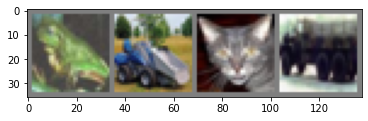

 frog truck   cat truck


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

接着定义一个CNN网络。

In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

定义loss函数－－Classification Cross-Entropy loss 和optimizer－－SGD with momentum.

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

训练网络时，循环数据并喂入网络。

In [43]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.175
[1,  4000] loss: 1.863
[1,  6000] loss: 1.670
[1,  8000] loss: 1.578
[1, 10000] loss: 1.526
[1, 12000] loss: 1.470
[2,  2000] loss: 1.379
[2,  4000] loss: 1.382
[2,  6000] loss: 1.345
[2,  8000] loss: 1.299
[2, 10000] loss: 1.296
[2, 12000] loss: 1.245
Finished Training


现在保存模型：

In [44]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

测试模型能力，先看看原数据

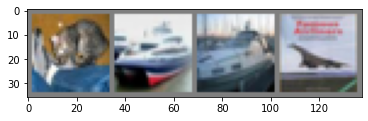

GroundTruth:    cat  ship  ship plane


In [45]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

给出预测数据：加载模型并预测一组

In [46]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [47]:
outputs = net(images)

In [48]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   frog   car  ship  ship


看看所有测试数据集上的结果

In [49]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 57 %


看看每一个类别的准确率：

In [50]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 74 %
Accuracy of  bird : 31 %
Accuracy of   cat : 43 %
Accuracy of  deer : 36 %
Accuracy of   dog : 37 %
Accuracy of  frog : 79 %
Accuracy of horse : 73 %
Accuracy of  ship : 75 %
Accuracy of truck : 54 %
